# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load FBM stroma lineage

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [7]:
stromal_celltypes = ['adipo-CAR', 'arteriolar fibroblast', 'tip EC', 'stromal macrophage', 'sinusoidal EC', 
                      'schwann cells', 'proliferating EC', 'osteoclast', 'osteochondral precursor', 
                      'osteoblast precursor',                                        
                     'osteoblast', 'myofibroblast', 'muscle stem cell', 'muscle', 'monocytoid macrophage',  
                     'erythroid macrophage', 'immature EC', 'endosteal fibroblast', 'early osteoblast', 'chondrocyte']

In [8]:
adata = adata[adata.obs['cell.labels'].isin(stromal_celltypes)].copy()

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
adipo-CAR                   353
arteriolar fibroblast        83
chondrocyte                  80
early osteoblast            280
endosteal fibroblast         54
erythroid macrophage         92
immature EC                  42
monocytoid macrophage       290
muscle                      131
muscle stem cell            254
myofibroblast                78
osteoblast                  363
osteoblast precursor        456
osteochondral precursor     191
osteoclast                 1221
proliferating EC             26
schwann cells                 9
sinusoidal EC               550
stromal macrophage         1464
tip EC                      362
dtype: int64

In [10]:
adata.shape

(6379, 33712)

# Pre-process the dataset

In [11]:
# normalise count data 
sc.pp.normalize_total(adata)

In [12]:
# log the count data 
sc.pp.log1p(adata)

In [13]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [14]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [15]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [16]:
# run pca
sc.tl.pca(adata, n_comps=50)

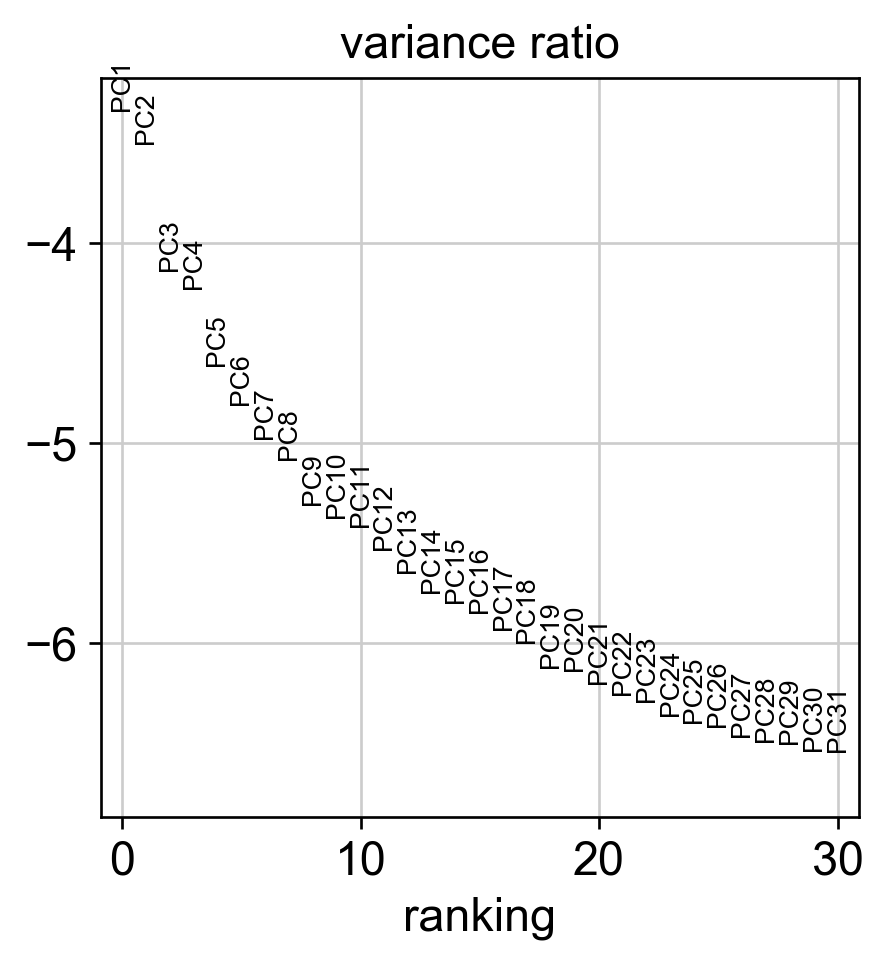

In [17]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [18]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [19]:
# run umap
sc.tl.umap(adata) 

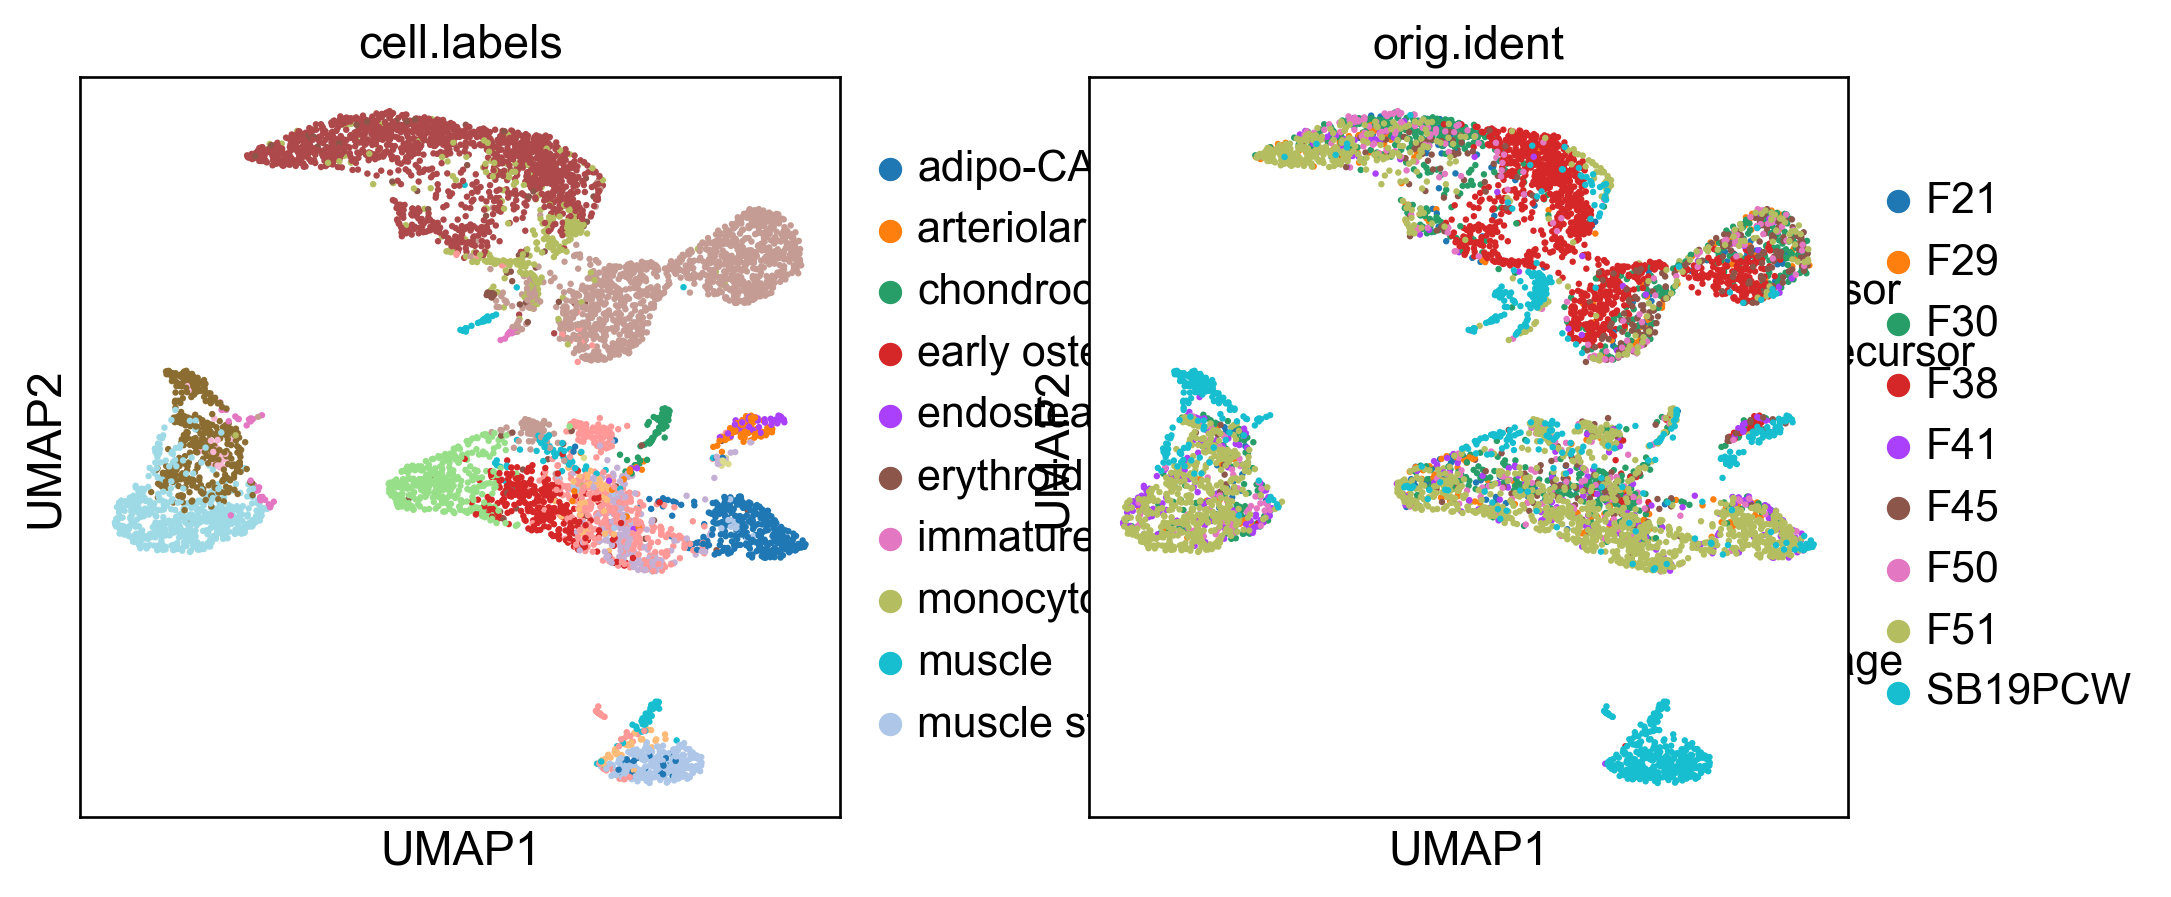

In [20]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [21]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [22]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [23]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [24]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

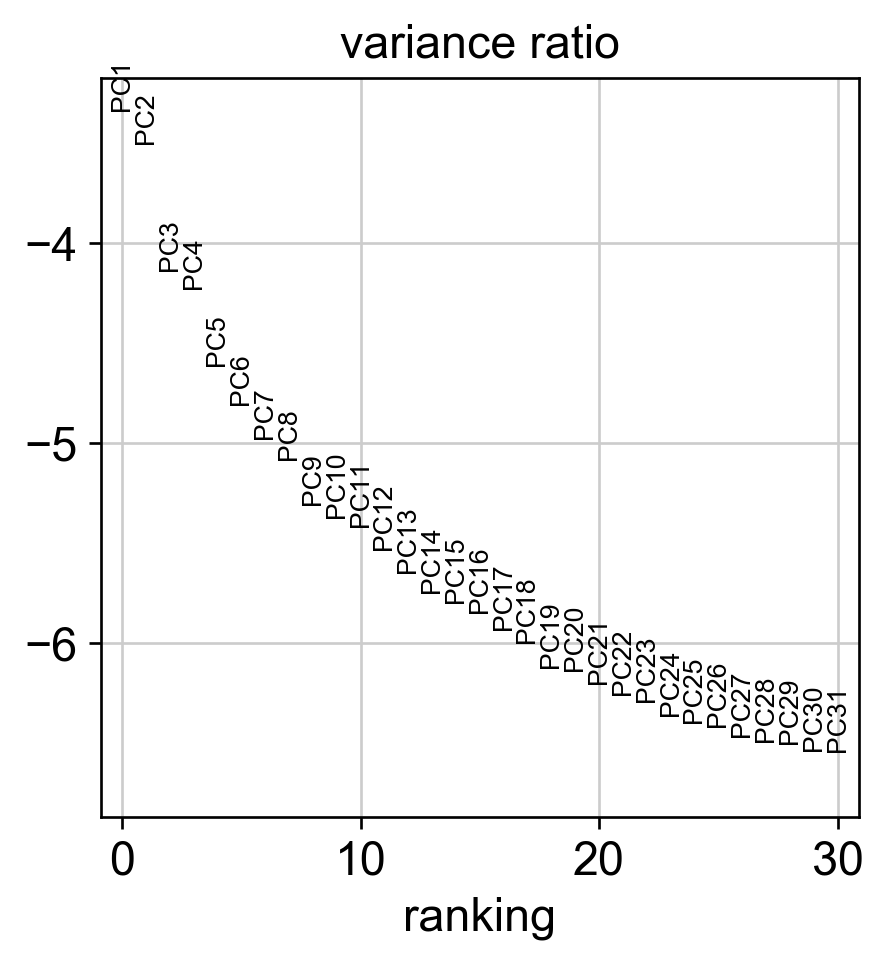

In [25]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [27]:
# run umap
sc.tl.umap(adata)

# Change the colours for the stromal cells

In [28]:
adata.obs["cell.labels"].cat.categories

Index(['adipo-CAR', 'arteriolar fibroblast', 'chondrocyte', 'early osteoblast', 'endosteal fibroblast', 'erythroid macrophage', 'immature EC', 'monocytoid macrophage', 'muscle', 'muscle stem cell', 'myofibroblast', 'osteoblast', 'osteoblast precursor', 'osteochondral precursor', 'osteoclast', 'proliferating EC', 'schwann cells', 'sinusoidal EC', 'stromal macrophage', 'tip EC'], dtype='object')

In [29]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(["muscle stem cell"], ["muscle"])
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['adipo-CAR', 'arteriolar fibroblast', 'chondrocyte', 'early osteoblast', 'endosteal fibroblast', 'erythroid macrophage', 'immature EC', 'monocytoid macrophage', 'muscle', 'myofibroblast', 'osteoblast', 'osteoblast precursor', 'osteochondral precursor', 'osteoclast', 'proliferating EC', 'schwann cells', 'sinusoidal EC', 'stromal macrophage', 'tip EC'], dtype='object')

In [30]:
final_order = ['stromal macrophage',
'monocytoid macrophage',
'erythroid macrophage',
'osteoclast',
'immature EC',
'sinusoidal EC',
'proliferating EC',
'tip EC',
'endosteal fibroblast',
'arteriolar fibroblast',
'myofibroblast',
'muscle',
'schwann cells',
'osteochondral precursor',
'adipo-CAR',
'osteoblast precursor',
'early osteoblast',
'osteoblast',
'chondrocyte']

adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(final_order)

In [31]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['stromal macrophage', 'monocytoid macrophage', 'erythroid macrophage', 'osteoclast', 'immature EC', 'sinusoidal EC', 'proliferating EC', 'tip EC', 'endosteal fibroblast', 'arteriolar fibroblast', 'myofibroblast', 'muscle', 'schwann cells', 'osteochondral precursor', 'adipo-CAR', 'osteoblast precursor', 'early osteoblast', 'osteoblast', 'chondrocyte'], dtype='object')

In [32]:
adata.obs["cell.labels"].cat.categories[2]

'erythroid macrophage'

In [33]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#1B6633' # stromal macrophage
new_colors[[1]] = '#D1DB94' # monocytoid macrophage
new_colors[[2]] = '#87AC3F' # erythroid macrophage
new_colors[[3]] = '#F59771' # osteoclast
new_colors[[4]] = '#196F8B' # immature EC
new_colors[[5]] = '#F9F06C' # sinusoidal EC
new_colors[[6]] = '#9E6B49' # proliferating EC
new_colors[[7]] = '#E6DEC1' # tip EC
new_colors[[8]] = '#F3C3DB' # endosteal fibroblast
new_colors[[9]] = '#64C5E4' # arteriolar fibroblast
new_colors[[10]] = '#AD83BB' # myofibroblast
new_colors[[11]] = '#bebebe' # muscle
new_colors[[12]] = '#48B9B4' # schwann cells
new_colors[[13]] = '#D43D6A' # osteochondral precursor
new_colors[[14]] = '#F3C19F' # adipo-CAR
new_colors[[15]] = '#8E88A8' # osteoblast precursor
new_colors[[16]] = '#86B3E0' # early osteoblast
new_colors[[17]] = '#3B50A2' # osteoblast
new_colors[[18]] = '#A9479A' # chondrocyte

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#1B6633', '#D1DB94', '#87AC3F', '#F59771', '#196F8B', '#F9F06C',
       '#9E6B49', '#E6DEC1', '#F3C3DB', '#64C5E4', '#AD83BB', '#bebebe',
       '#48B9B4', '#D43D6A', '#F3C19F', '#8E88A8', '#86B3E0', '#3B50A2',
       '#A9479A', '#8c6d31'], dtype='<U7')

# Run UMAPs

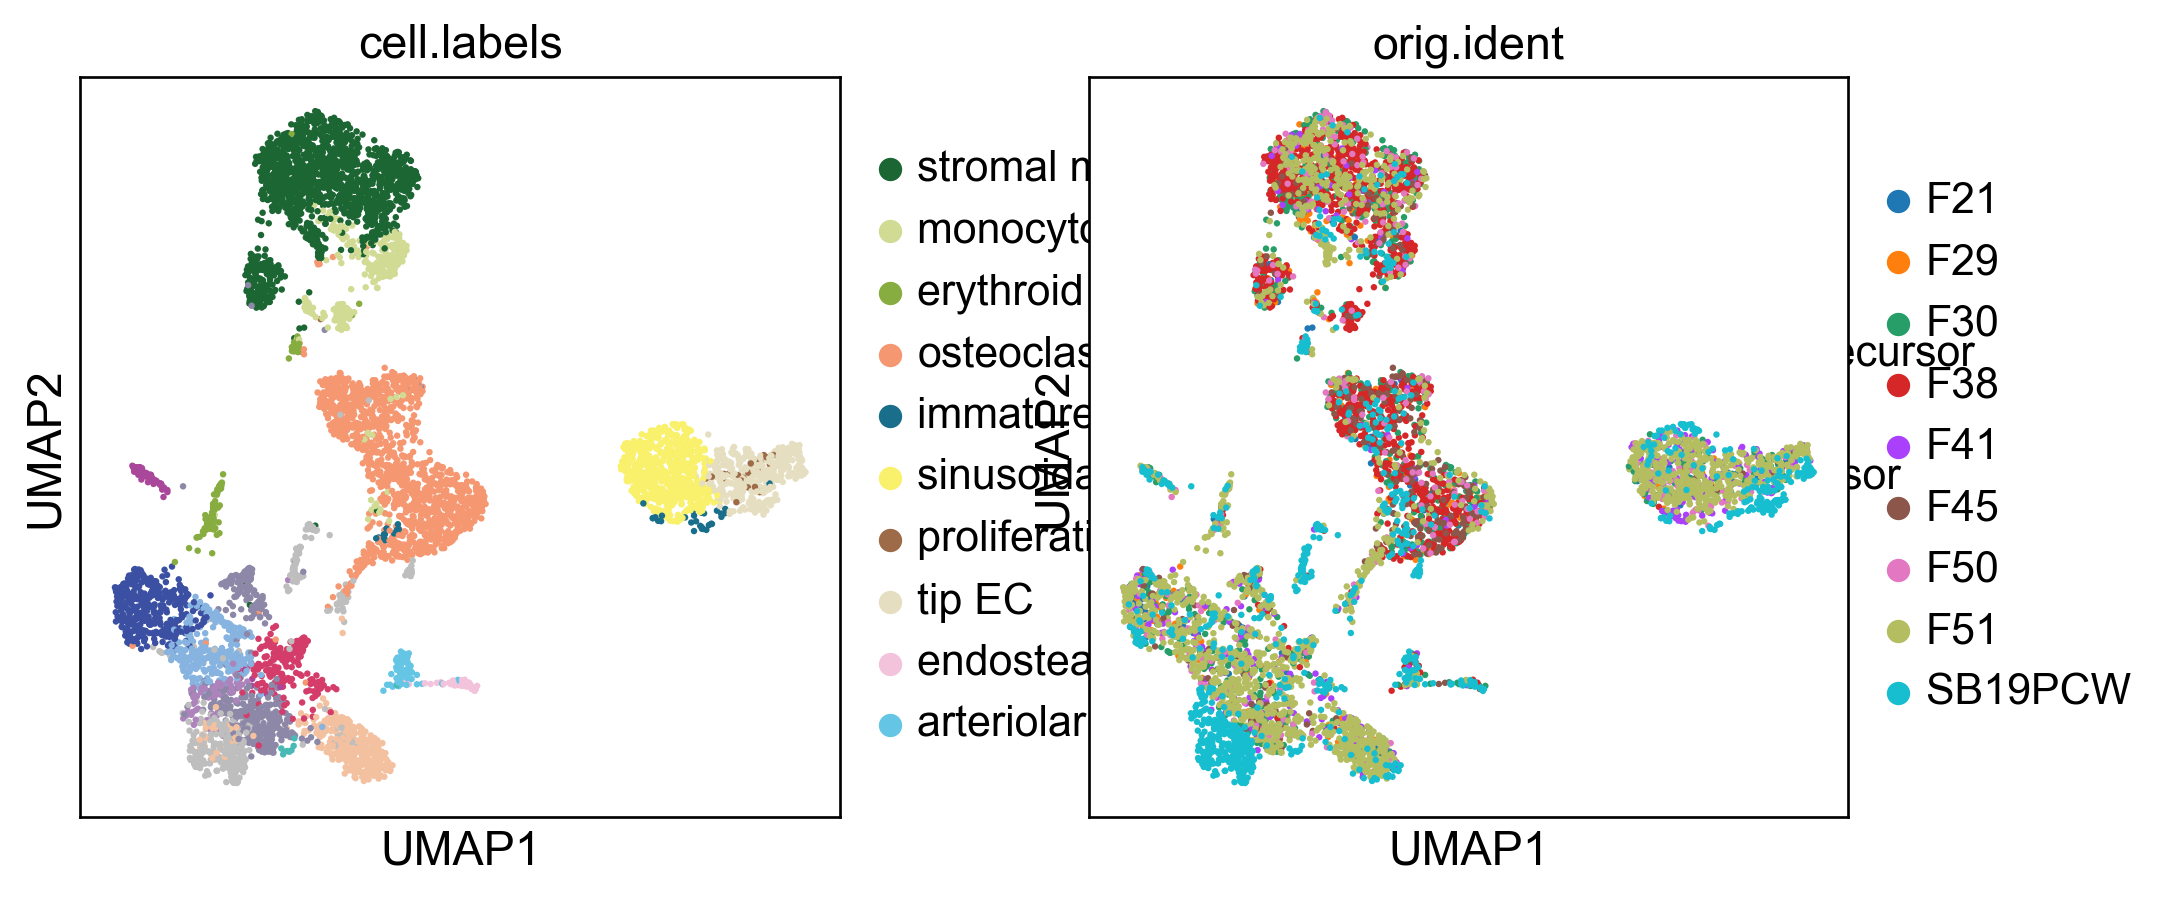

In [34]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

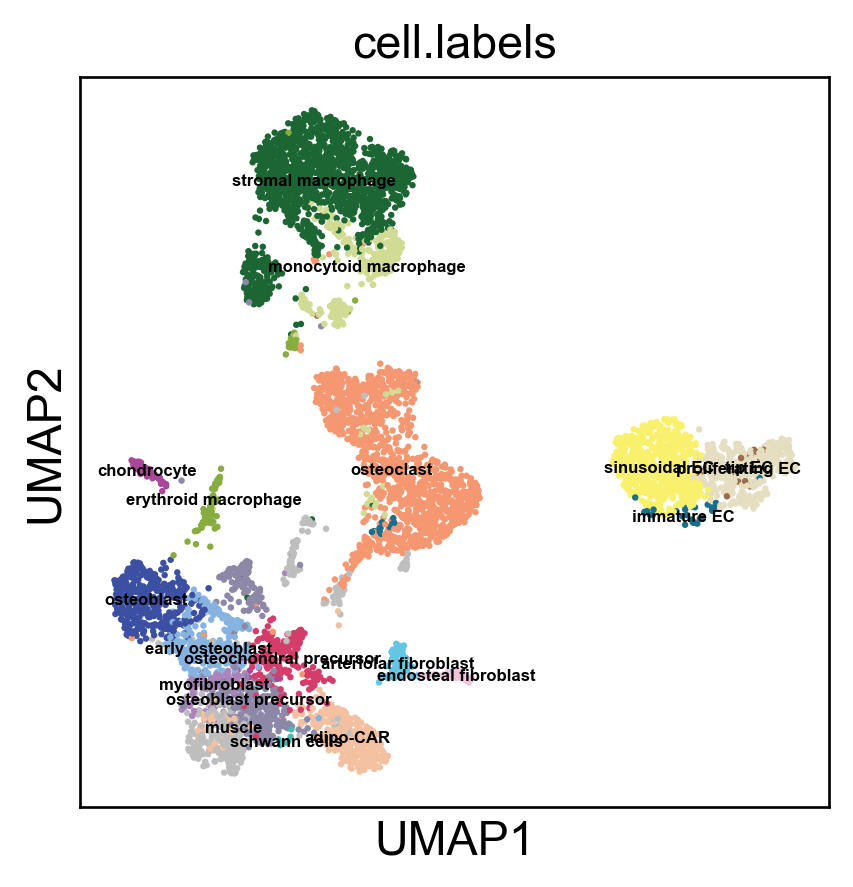

In [35]:
sc.pl.umap(adata, color=['cell.labels'], legend_loc="on data", size=15, legend_fontsize=5) 

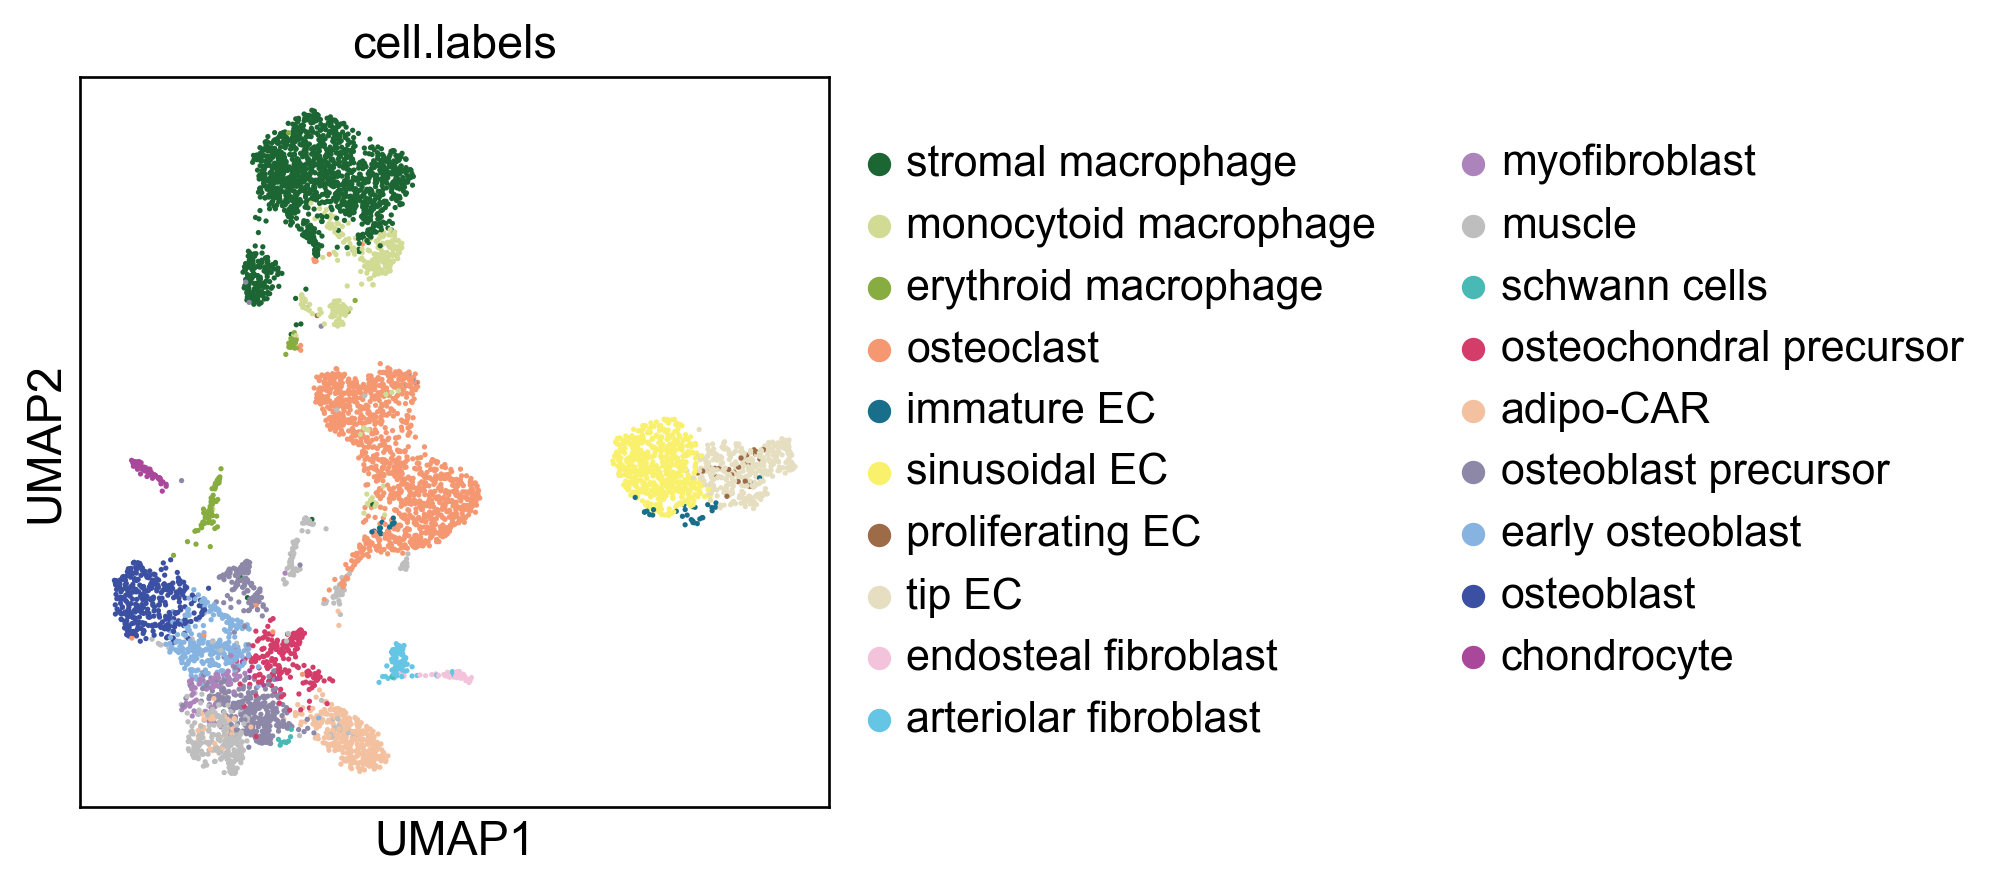

In [36]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=10, save="fig6a_stroma_umap_20210126.pdf") 

# Save cell numbers

In [37]:
cell_numbers = adata.obs.groupby(["fetal.ids", "cell.labels"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/stroma_nrs_by_fetal_ids_20210126.csv")
cell_numbers

fetal.ids           cell.labels            
F21_male_16+2PCW    stromal macrophage          39
                    monocytoid macrophage        7
                    erythroid macrophage         6
                    osteoclast                  41
                    sinusoidal EC               12
                    proliferating EC             1
                    tip EC                       7
                    myofibroblast                1
                    osteochondral precursor      8
                    adipo-CAR                    3
                    osteoblast precursor        16
                    early osteoblast            13
                    osteoblast                  24
                    chondrocyte                  1
F29_female_17+0PCW  stromal macrophage          84
                    monocytoid macrophage       15
                    erythroid macrophage         6
                    osteoclast                  69
                    sinusoidal EC     

# Save the data

In [38]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [39]:
adata.X

<6379x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 15838577 stored elements in Compressed Sparse Row format>

In [40]:
adata.raw.X

<6379x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 17745868 stored elements in Compressed Sparse Row format>

In [41]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig6a_stroma_dr_20210126.h5ad")